In [ ]:
!pip install tensorflow-gpu

#**Using pure TensorFlow without auto-differentiation to build a 3 layer neural network**

In [ ]:
import tensorflow as tf 
import numpy
import math
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer

In [100]:
#generating 3-d non linear data

n_samples = 200
d = 3
x = tf.random.normal([n_samples, d], -1, 1)  

weights_true = tf.cast(tf.constant([[5, 1, 6], [1, 6, 1]]), tf.float32)
weights_true = tf.transpose(weights_true)

bias_true = tf.cast(tf.constant([[1], [1]]), tf.float32)
bias_true = tf.transpose(bias_true)

y_true = tf.matmul((x ** 2), weights_true) + tf.matmul(x, weights_true) + bias_true
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

x: (200, 3), weights: (3, 2), bias: (1, 2), y: (200, 2)


###Plotting the data

In [101]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_3d(x, y, y_pred=None):
  X_embedded = TSNE(n_components=2).fit_transform(x)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(X_embedded[:, 0], X_embedded[:, 1], y[:, 0], label='underlying function') 
  if y_pred is not None:
    ax.scatter(X_embedded[:, 0], X_embedded[:, 1], y_pred[:, 0], label='our function')
  plt.legend()

###Plotting both the labels in y_true

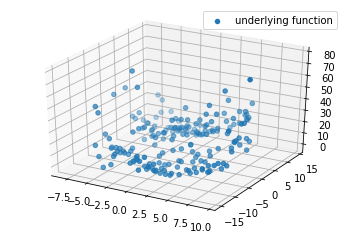

In [126]:
plot_3d(x, y_true)

###Building linear layer using tensorflow and defining the model class

In [103]:
class Linear(keras.layers.Layer):
  def __init__(self, units=32):
    super(Linear, self).__init__()
    self.units = units
  
  def build(self, input_shape):
    self.w = self.add_weight(shape=(input_shape[-1], self.units),
                             initializer='random_normal',
                             trainable=True)
    self.b = self.add_weight(shape=(self.units,),
                             initializer='random_normal', 
                             trainable=True)
  
  def call(self, inputs):
    return tf.matmul(inputs, self.w) + self.b

###Defining the model calss using the linear class defined above

In [104]:
class ActivityRegularization(keras.layers.Layer):
  def __init__(self, rate=1e-2):
    super(ActivityRegularization, self).__init__()
    self.rate = rate
  
  def call(self, inputs):
    self.add_loss(self.rate * tf.reduce_sum(inputs))
    return inputs

In [112]:
class MLP(Layer):
    """Simple stack of Linear layers."""

    def __init__(self):
        super(MLP, self).__init__()
        self.linear_1 = Linear(32)
        self.linear_2 = Linear(32)
        self.linear_3 = Linear(2)

    def call(self, inputs):
        x = self.linear_1(inputs)
        x = tf.nn.relu(x)
        x = self.linear_2(x)
        x = tf.nn.relu(x)
        return self.linear_3(x)

In [124]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.MeanSquaredError()
loss_metric = tf.keras.metrics.Mean()

dataset = tf.data.Dataset.from_tensor_slices((x, y_true))
dataset = dataset.shuffle(buffer_size=1).batch(30)

epochs = 700

model = MLP()

for epoch in range(epochs):
    for step, (x_batch, y_batch) in enumerate(dataset):
        with tf.GradientTape() as tape:
            # Forward Pass
            y_pred_batch = model(x_batch)
            # Compute loss
            loss = loss_fn(y_batch, y_pred_batch)
            loss += sum(model.losses)

        grads = tape.gradient(loss, model.trainable_weights) 
        optimizer.apply_gradients(zip(grads, model.trainable_weights)) 

        loss_metric(loss)
    if epoch % 100 == 0:
      print(f'Epoch {epoch}, loss {loss_metric.result()}')

Epoch 0, loss 257.32257080078125
Epoch 100, loss 29.185529708862305
Epoch 200, loss 17.321449279785156
Epoch 300, loss 12.622745513916016
Epoch 400, loss 10.0752592086792
Epoch 500, loss 8.420105934143066
Epoch 600, loss 7.260507106781006


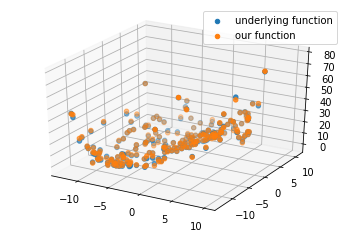

In [125]:
plot_3d(x, y_true, model(x))